<a href="https://colab.research.google.com/github/KhosrojerdiA/Machine-Learning/blob/main/Transfer_Learning_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 VGGNet trained on the ImageNet dataset as a feature extractor.

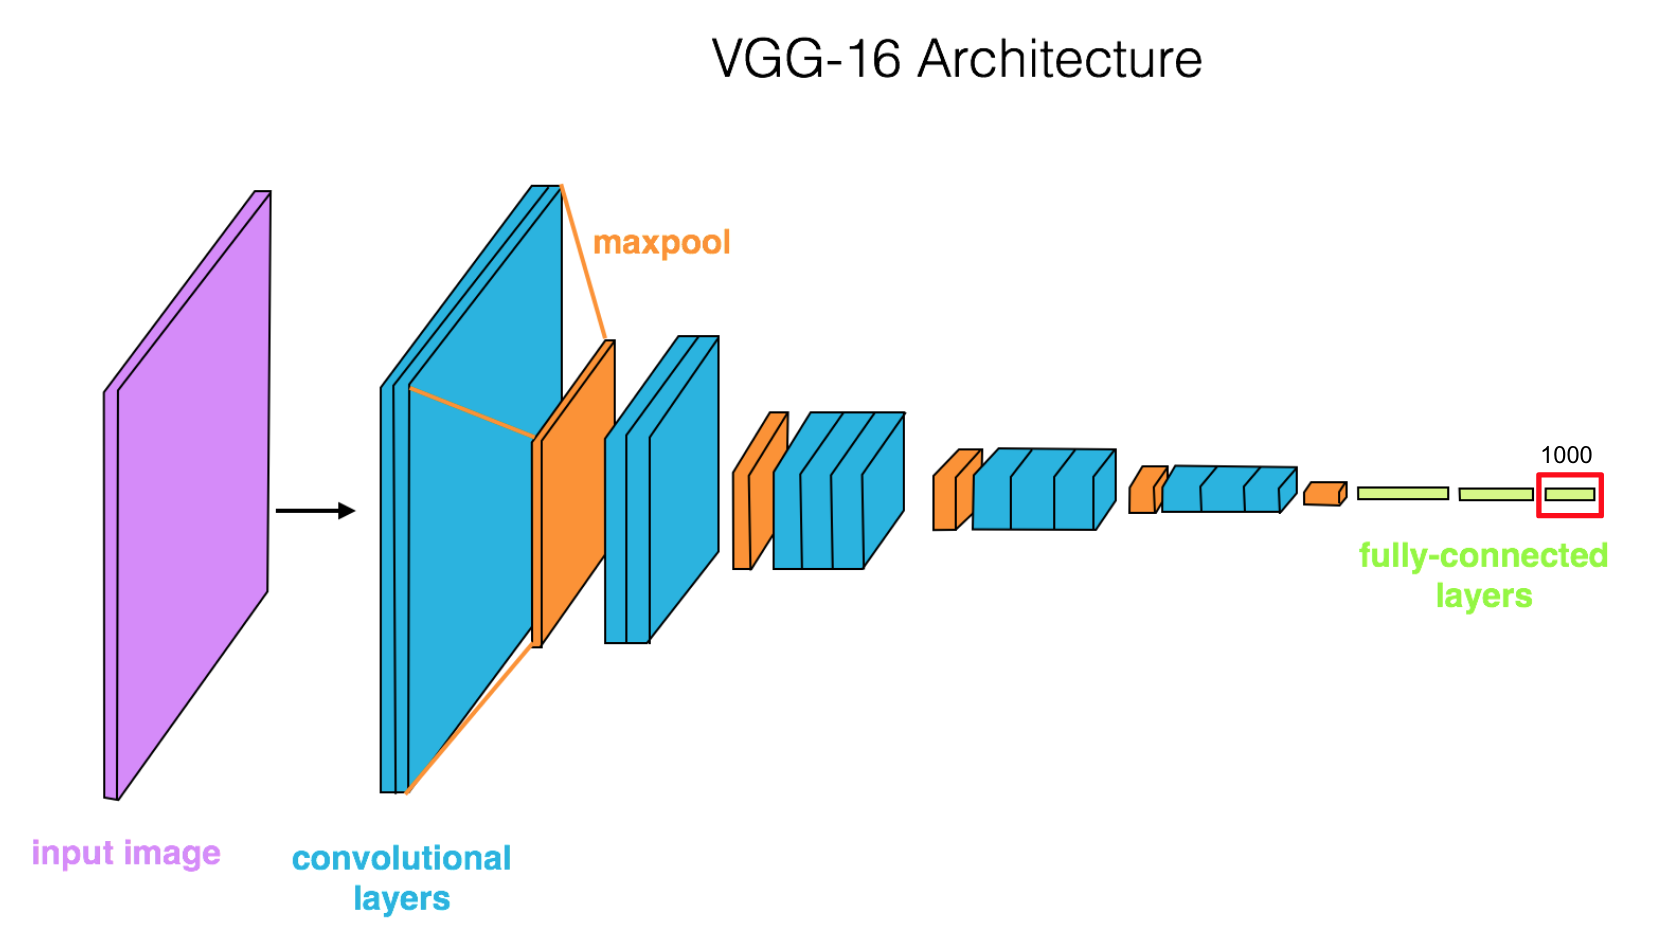

In [ ]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


#Extract from zip

In [ ]:
import zipfile
import os
#/content/flower-photos.zip
# Define the path to your zip file
zip_file_path = '/content/flower-photos.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/flower_photos')

# List files in the extracted folder
extracted_path = '/content/flower_photos'
print(os.listdir(extracted_path))

['flower_photos', '__MACOSX']


#Directories

Data: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb

In [ ]:
#/content/flower_photos/flower_photos/train
data_dir = '/content/flower_photos/flower_photos/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#Transform Data

In [ ]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


#Data Loaders

In [ ]:
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

#Visualize

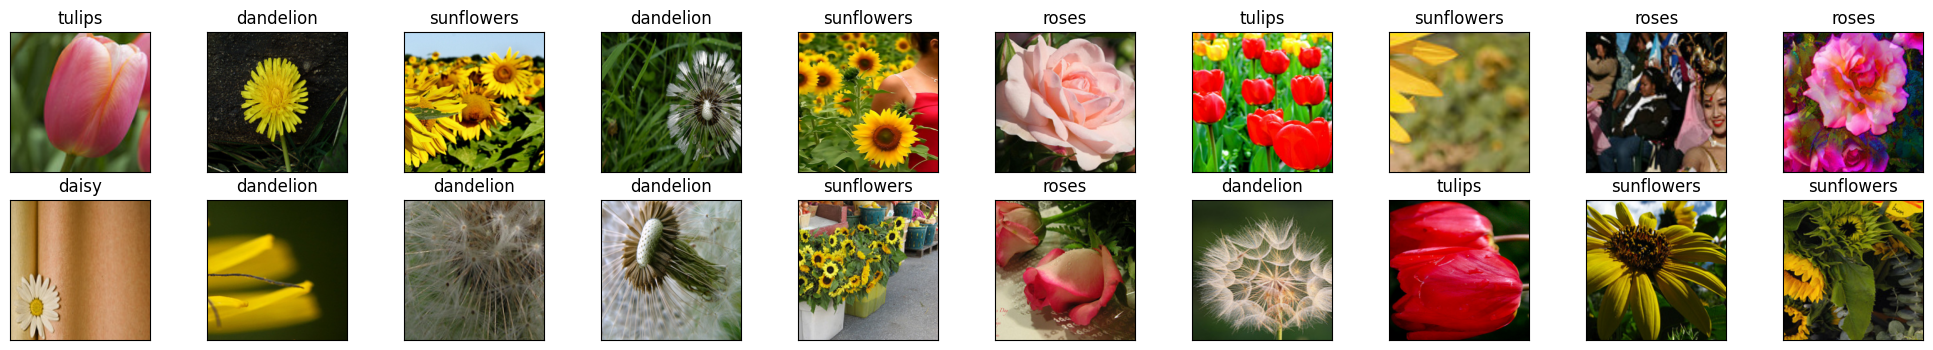

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loader is already defined
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()  # Convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

plt.show()

#Model
- Load in a pre-trained VGG16 model
- "Freeze" all the parameters, so the net acts as a fixed feature extractor
- Remove the last layer
- Replace the last layer with a linear classifier of our own


In [ ]:
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
1000


##Freeze all Layers

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

##Final Layer (Classifier)

In [ ]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

5


#Loss and Optimizer

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

#Training

In [ ]:
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()

        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.4923664689064027
Epoch 1, Batch 40 loss: 1.2970780253410339
Epoch 1, Batch 60 loss: 1.2241447210311889
Epoch 1, Batch 80 loss: 1.1049562454223634
Epoch 1, Batch 100 loss: 1.0385598957538604
Epoch 1, Batch 120 loss: 1.0248247832059860
Epoch 1, Batch 140 loss: 0.9435824722051620
Epoch 2, Batch 20 loss: 0.8407627731561661
Epoch 2, Batch 40 loss: 0.8515130072832108
Epoch 2, Batch 60 loss: 0.7829952597618103
Epoch 2, Batch 80 loss: 0.7591375574469567
Epoch 2, Batch 100 loss: 0.7649525433778763
Epoch 2, Batch 120 loss: 0.7457944974303246
Epoch 2, Batch 140 loss: 0.7792306393384933


#Testing

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.688250

Test Accuracy of daisy: 78% (72/92)
Test Accuracy of dandelion: 87% (116/132)
Test Accuracy of roses: 71% (65/91)
Test Accuracy of sunflowers: 77% (78/101)
Test Accuracy of tulips: 75% (93/124)

Test Accuracy (Overall): 78% (424/540)


#Visualize Test Results
Sample

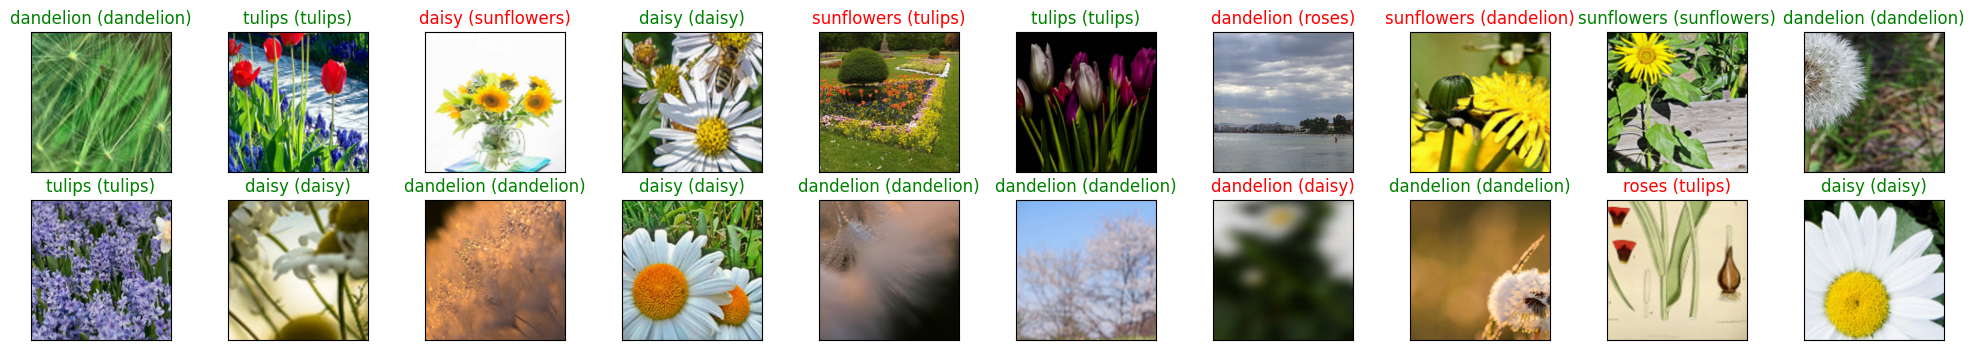

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_loader, vgg16, classes, and train_on_gpu are already defined
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Corrected to use next() function

# Move model inputs to CUDA if GPU is available
if train_on_gpu:
    images = images.cuda()

# Get sample outputs
output = vgg16(images)

# Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy()) if train_on_gpu else np.squeeze(preds_tensor.numpy())

# Convert images to numpy for display
images = images.cpu().numpy() if train_on_gpu else images.numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx] == labels[idx].item() else "red"))

plt.show()